# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [1]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import csv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
%matplotlib inline
from sklearn.decomposition import PCA 
import pandas as pd
from pandas.io import sql
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics


#### Step 2: Examine your data 

In [2]:
cancel = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/airport_cancellations.csv")

ops = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/Airport_operations.csv")

ap = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/airports.csv")

# ajbentley

# EKandTower


### Intro: Write a problem statement / aim for this project

Objective: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.


First step is to identify which airports are the "problem children." We can do this with PCA and clustering.

Will run naive PCA and pare down on features to reduce overfitting until we can get at least 70% explained on 3 features. Then we'll use those features to cluster.

Clustering on PCAs should show what airports have higher than normal delay times and whose operations have been flat or worsening.

Once we ID what airports are the problems we can figure out what they have in common. 

Once they have been identified we can do classification to find out what the specific metrics are that are impacting their efficiancy. 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [3]:
# !conda install pyscopg2
# !pip install ipython-sql


In [4]:
%load_ext sql


In [5]:
# # from forzavitale repo

# engine = create_engine('postgresql://@localhost:5432/airportdb')

# cancel.to_sql('cancel', engine)
# operations.to_sql('ops', engine)
# airports.to_sql('ap', engine)

# %%sql 
# postgresql://@localhost:5432/airportdb

In [6]:
# cancel = pd.read_sql("cancel", engine)
# operations = pd.read_sql("ops", engine)
# airports = pd.read_sql("ap", engine)

In [7]:
cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

In [8]:
df = cancel.join(ap, rsuffix='ap')
df.pop('AP_NAMEap');

In [9]:
df = df.join(ops, rsuffix='ops')

#### 1.2 What are the risks and assumptions of our data? 

While there is considerable information presented there is a massive amount of information that feels like it most be colinear (several flavors of delays and arrivals, all of which probably correlate highly). It would be useful to see if there is a way to combine.

There's also data that are missing. It would be significant to see meteorological data, which I have to imagine the FAA collects, to show whether temperature and precipitation have seen significant shifts in this time.

It could be useful to see whether there is any difference in monthly numbers. Has tourism increased?

Once we get down to the individual airports that we need to consider it would be good to see whether there have been changes in the airlines serving the airport or in the sources / destinations of the planes. If flights from Denver tend to be late and they've just started a new direct flight from Denver to DC then the delays in DC would change.

There is a mixture of measurement scales--total counts, coordinates, percentages, and minutes. Data will definitely need standardization to be usable.



### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [10]:
df.describe()

,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,Latitude,Longitude,year,departures for metric computation,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
count,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,...,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000,805.000000
mean,2008.986335,1292.038509,1333.124224,173.315528,169.413665,2488.650932,30.522748,-93.577507,2009.014907,111331.108075,...,0.719039,0.760144,13.299888,13.813453,3.604907,16.059615,2.930112,1.385006,3.322807,13.743565
std,3.158116,1835.961943,1975.224868,172.345539,228.521615,1607.433809,2.806227,12.880292,3.152394,99041.431112,...,0.088554,0.068339,4.076106,3.836060,2.397139,4.937230,1.199621,0.879909,1.029183,3.907379
min,2004.000000,0.000000,0.000000,0.000000,0.000000,254.000000,17.701556,-177.381308,2004.000000,261.000000,...,0.245700,0.349500,5.350000,7.040000,0.000000,6.290000,0.950000,0.000000,1.230000,6.330000
25%,2006.000000,349.000000,314.000000,62.000000,41.000000,880.000000,29.607333,-97.969472,2006.000000,39279.000000,...,0.686300,0.738100,10.950000,11.330000,2.230000,12.980000,2.060000,0.820000,2.630000,11.270000
50%,2009.000000,663.000000,642.000000,110.000000,84.000000,2900.000000,31.179278,-93.745023,2009.000000,73741.000000,...,0.736200,0.769300,12.670000,12.930000,3.030000,15.240000,2.660000,1.120000,3.150000,13.070000
75%,2012.000000,1472.000000,1523.000000,236.000000,190.000000,3319.000000,32.493417,-84.557425,2012.000000,166455.000000,...,0.770700,0.797500,14.820000,15.720000,4.190000,17.850000,3.620000,1.770000,3.850000,15.190000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,5251.000000,33.303458,-64.801722,2014.000000,491826.000000,...,0.897400,0.880300,40.800000,35.760000,18.940000,40.870000,7.820000,6.180000,7.520000,34.280000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 804 non-null object
ALIAS                                 631 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

In [12]:
# sns.pairplot(cancel, kind="scatter")

In [13]:
# sns.pairplot(ops, kind="scatter")

In [14]:

# df['AP_NAME'] = LabelEncoder().fit_transform(df['AP_NAME'])
df['FAA REGION'] = LabelEncoder().fit_transform(df['FAA REGION'])
df['LocID'] = LabelEncoder().fit_transform(df['LocID'])

df['ALIAS'] = LabelEncoder().fit_transform(df['ALIAS'])
df['Facility Type'] = LabelEncoder().fit_transform(df['Facility Type'])
df['COUNTY'] = LabelEncoder().fit_transform(df['COUNTY'])
df['CITY'] = LabelEncoder().fit_transform(df['CITY'])
df['STATE'] = LabelEncoder().fit_transform(df['STATE'])
df['AP Type'] = LabelEncoder().fit_transform(df['AP Type'])
df['Boundary Data Available'] = LabelEncoder().fit_transform(df['Boundary Data Available'])
df['airport'] = LabelEncoder().fit_transform(df['airport'])




/Users/ajbentley/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [15]:
df.head(30)

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,LocID,ALIAS,Facility Type,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,3443.0,687,280,0,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,5088.0,799,0,0,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,2886.0,635,13,0,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,2879.0,769,8,0,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,2883.0,798,15,0,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2009.0,192.0,162.0,74.0,26.0,2884.0,655,12,0,...,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,ABQ,2010.0,222.0,177.0,71.0,50.0,2881.0,556,10,0,...,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,ABQ,2011.0,345.0,294.0,77.0,61.0,5087.0,800,0,0,...,0.7758,0.8022,10.81,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,ABQ,2012.0,237.0,181.0,65.0,60.0,5086.0,325,0,0,...,0.7940,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,ABQ,2013.0,232.0,212.0,62.0,46.0,3442.0,686,160,0,...,0.7402,0.7554,12.56,10.77,2.64,14.28,1.60,0.92,2.35,12.76


In [16]:
# create df that only references airport name, year, and delay and arrival information (continuous, not categorical data)


dfn = ['AP_NAME', 'Year', 'Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions',\
       'departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df[dfn])

dfn.columns = ['ap_name', 'year','D_cancel', 'A_cancel','D_divert','A_divert','D_4met','A_4met', '%on/t_gate_D',\
               '%on/t_ap_D', '%on/t_gate_A', 'avg_taxi_out_time', 'avg_taxi_out_del', 'avg_ap_D_del',\
               'avg_airborne_del', 'avg_taxi_in_del', 'avg_block_del','avg_gate_A_del']

dfn.head()
# dfn.to_csv('/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
# assets/dfn.csv')

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del,avg_gate_A_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,0.7921,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,0.8001,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,0.7746,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,0.7647,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,0.7875,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [17]:
# Adding change columns for all 

dfn['Chg_D_cancel'] = dfn['D_cancel'].pct_change(5)
dfn['Chg_A_cancel'] = dfn['A_cancel'].pct_change(5)
dfn['Chg_D_divert'] = dfn['D_divert'].pct_change(5)
dfn['Chg_A_divert'] = dfn['A_divert'].pct_change(5)
dfn['Chg_D_4met'] = dfn['D_4met'].pct_change(5)
dfn['Chg_A_4met'] = dfn['A_4met'].pct_change(5)
dfn['Chg_%on/t_gate_D'] = dfn['%on/t_gate_D'].pct_change(5)
dfn['Chg_%on/t_ap_D'] = dfn['%on/t_ap_D'].pct_change(5)
dfn['Chg_%on/t_gate_A'] = dfn['%on/t_gate_A'].pct_change(5)
dfn['Chg_avg_taxi_out_time'] = dfn['avg_taxi_out_time'].pct_change(5)
dfn['Chg_avg_taxi_out_del'] = dfn['avg_taxi_out_del'].pct_change(5)
dfn['Chg_avg_ap_D_del'] = dfn['avg_ap_D_del'].pct_change(5)
dfn['Chg_avg_airborne_del'] = dfn['avg_airborne_del'].pct_change(5)
dfn['Chg_avg_taxi_in_del'] = dfn['avg_taxi_in_del'].pct_change(5)
dfn['Chg_avg_block_del'] = dfn['avg_block_del'].pct_change(5)
dfn['Chg_avg_gate_A_del'] = dfn['avg_gate_A_del'].pct_change(5)

dfn.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# verify I have the right columns for the next function
#(showing 1:19 shows that I am looking for 2:18)

# dfn.columns[1:19].tolist()

In [19]:
# creating new database with change columns which I'll then calculate a 3-year average change and delete all rows
# except for 2014, where the trend will "live" and which I'll splice into a 2014-only dataframe.
# dfa = df[df.columns[38:-13]]
# dfn_chg = pd.DataFrame(dfn[dfn.columns[18:]])
# dfn_chg.head()



In [20]:


########  DD, this is where the code starts that I need help with.




# last_city = "TUS"
# def kill_first(x):
#     if x['year'] <= 2013:
#         return pd.np.nan
#     else:
#         return x['Chg']

In [21]:
dfn.columns.tolist()

['ap_name',
 'year',
 'D_cancel',
 'A_cancel',
 'D_divert',
 'A_divert',
 'D_4met',
 'A_4met',
 '%on/t_gate_D',
 '%on/t_ap_D',
 '%on/t_gate_A',
 'avg_taxi_out_time',
 'avg_taxi_out_del',
 'avg_ap_D_del',
 'avg_airborne_del',
 'avg_taxi_in_del',
 'avg_block_del',
 'avg_gate_A_del',
 'Chg_D_cancel',
 'Chg_A_cancel',
 'Chg_D_divert',
 'Chg_A_divert',
 'Chg_D_4met',
 'Chg_A_4met',
 'Chg_%on/t_gate_D',
 'Chg_%on/t_ap_D',
 'Chg_%on/t_gate_A',
 'Chg_avg_taxi_out_time',
 'Chg_avg_taxi_out_del',
 'Chg_avg_ap_D_del',
 'Chg_avg_airborne_del',
 'Chg_avg_taxi_in_del',
 'Chg_avg_block_del',
 'Chg_avg_gate_A_del']

In [22]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

# df14 = pd.DataFrame(dfn.loc[df['Year'] == 2014])

# df14.replace([np.inf, -np.inf], np.nan)
# df14.dropna(inplace=True)
# df14.head();

# df14.head()


,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
10,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
21,ANC,2014.0,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,...,0.021696,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630
32,ATL,2014.0,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,...,0.015949,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093
43,AUS,2014.0,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,...,-0.064631,-0.070628,-0.064508,0.007712,0.004878,0.274734,-0.004425,-0.068966,0.070632,0.272584
54,BDL,2014.0,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,...,-0.047431,-0.042674,-0.045884,-0.019969,-0.107266,0.167072,-0.212121,0.104651,-0.098976,0.264103


In [23]:
df14.columns.tolist()

['ap_name',
 'year',
 'D_cancel',
 'A_cancel',
 'D_divert',
 'A_divert',
 'D_4met',
 'A_4met',
 '%on/t_gate_D',
 '%on/t_ap_D',
 '%on/t_gate_A',
 'avg_taxi_out_time',
 'avg_taxi_out_del',
 'avg_ap_D_del',
 'avg_airborne_del',
 'avg_taxi_in_del',
 'avg_block_del',
 'avg_gate_A_del',
 'Chg_D_cancel',
 'Chg_A_cancel',
 'Chg_D_divert',
 'Chg_A_divert',
 'Chg_D_4met',
 'Chg_A_4met',
 'Chg_%on/t_gate_D',
 'Chg_%on/t_ap_D',
 'Chg_%on/t_gate_A',
 'Chg_avg_taxi_out_time',
 'Chg_avg_taxi_out_del',
 'Chg_avg_ap_D_del',
 'Chg_avg_airborne_del',
 'Chg_avg_taxi_in_del',
 'Chg_avg_block_del',
 'Chg_avg_gate_A_del']

In [24]:
df14.pop('year')

10     2014.0
21     2014.0
32     2014.0
43     2014.0
54     2014.0
65     2014.0
76     2014.0
87     2014.0
98     2014.0
109    2014.0
120    2014.0
131    2014.0
142    2014.0
153    2014.0
164    2014.0
175    2014.0
186    2014.0
197    2014.0
208    2014.0
219    2014.0
230    2014.0
241    2014.0
263    2014.0
274    2014.0
285    2014.0
296    2014.0
307    2014.0
318    2014.0
329    2014.0
340    2014.0
        ...  
461    2014.0
472    2014.0
483    2014.0
494    2014.0
505    2014.0
516    2014.0
527    2014.0
538    2014.0
556    2014.0
567    2014.0
578    2014.0
589    2014.0
600    2014.0
611    2014.0
622    2014.0
633    2014.0
650    2014.0
661    2014.0
672    2014.0
683    2014.0
694    2014.0
705    2014.0
716    2014.0
727    2014.0
738    2014.0
749    2014.0
760    2014.0
771    2014.0
782    2014.0
793    2014.0
Name: year, dtype: float64

In [25]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 10 to 793
Data columns (total 33 columns):
ap_name                  70 non-null object
D_cancel                 70 non-null float64
A_cancel                 70 non-null float64
D_divert                 70 non-null float64
A_divert                 70 non-null float64
D_4met                   70 non-null int64
A_4met                   70 non-null int64
%on/t_gate_D             70 non-null float64
%on/t_ap_D               70 non-null float64
%on/t_gate_A             70 non-null float64
avg_taxi_out_time        70 non-null float64
avg_taxi_out_del         70 non-null float64
avg_ap_D_del             70 non-null float64
avg_airborne_del         70 non-null float64
avg_taxi_in_del          70 non-null float64
avg_block_del            70 non-null float64
avg_gate_A_del           70 non-null float64
Chg_D_cancel             70 non-null float64
Chg_A_cancel             70 non-null float64
Chg_D_divert             70 non-null float64


In [26]:
# sns.pairplot(dfn, kind="scatter")

In [27]:
# ax = sns.regplot(x="departures for metric computation", y="arrivals for metric computation", data=df14)


In [28]:
# ax = sns.regplot(x="percent on-time gate departures", y="percent on-time gate arrivals", data=df14)


In [29]:
# ax = sns.regplot(x="average taxi in delay", y="average taxi out delay", data=df14)


In [30]:
# ax = sns.regplot(x="average_taxi_out_time", y="average taxi out delay", data=df14)


In [31]:
# fig = plt.figure(figsize=(9,7))
# ax = fig.gca()

# ax = sns.regplot('percent on-time gate departures', 'percent on-time airport departures', data=df14, fit_reg=False, scatter_kws={'s':70}, ax=ax)
# ax.set_ylabel('% On-time Gate Departures', fontsize=16)
# ax.set_xlabel('% On-time Airport Departures', fontsize=16)

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(12) 
    
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(12) 
    
# ax.set_title('% Gate vs Airport Departures\n', fontsize=20)

# plt.show()

#### Are there any unique values? 

They're almost all unique values. 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [53]:
dfn.replace([np.inf, -np.inf], np.nan, inplace=True)
dfn.dropna(inplace=True)

dfn.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
5,ABQ,2009.0,192.0,162.0,74.0,26.0,42550,42704,0.8341,0.8147,...,0.038730,0.043283,0.038253,-0.001011,-0.222222,-0.136364,-0.292683,0.108434,-0.223529,-0.147194
6,ABQ,2010.0,222.0,177.0,71.0,50.0,42302,42169,0.8144,0.7907,...,0.000491,-0.001893,0.005749,0.016343,-0.104803,0.033929,-0.265487,0.067416,-0.188034,-0.000977
7,ABQ,2011.0,345.0,294.0,77.0,61.0,42283,42297,0.8072,0.7758,...,0.011149,0.000258,0.035631,0.061678,0.162037,0.019465,-0.254717,0.000000,-0.296992,-0.100677
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.026733,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.048501,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498


In [51]:
dfn.describe()

,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
count,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,...,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000,791.000000
mean,2008.975980,1310.620733,1352.718078,175.407080,171.543616,111857.237674,111384.443742,0.772547,0.720707,0.761979,...,-0.001040,0.003913,-0.000166,0.030320,0.320098,0.058525,0.153957,inf,0.099524,0.052542
std,3.157179,1846.705498,1987.029399,173.102629,229.933381,98103.008380,97740.148644,0.069717,0.085544,0.064593,...,0.101267,0.140069,0.099126,0.266719,1.805596,0.366898,0.679451,NaN,0.527724,0.332990
min,2004.000000,0.000000,0.000000,0.000000,0.000000,261.000000,259.000000,0.278600,0.276700,0.349500,...,-0.615773,-0.601150,-0.482674,-0.554736,-1.000000,-0.747295,-0.758182,-1.000000,-0.684956,-0.602326
25%,2006.000000,357.500000,326.000000,63.000000,41.000000,39711.500000,39542.500000,0.747800,0.686750,0.739100,...,-0.042187,-0.051013,-0.047613,-0.111491,-0.285111,-0.139341,-0.276774,-0.298936,-0.230199,-0.154919
50%,2009.000000,689.000000,655.000000,113.000000,86.000000,75511.000000,74918.000000,0.782400,0.737000,0.769600,...,0.002590,0.005295,0.007390,-0.007096,-0.068493,-0.005806,-0.059406,-0.020408,-0.056213,-0.032733
75%,2012.000000,1491.500000,1555.500000,238.000000,190.500000,166469.500000,165560.500000,0.809450,0.770450,0.797600,...,0.042291,0.062300,0.049311,0.116525,0.292332,0.140001,0.326750,0.355655,0.271012,0.181837
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,...,0.767475,0.765641,0.695053,1.829114,26.600000,2.065702,4.261905,inf,3.166667,1.529592


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118da7390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1201be310>]], dtype=object)

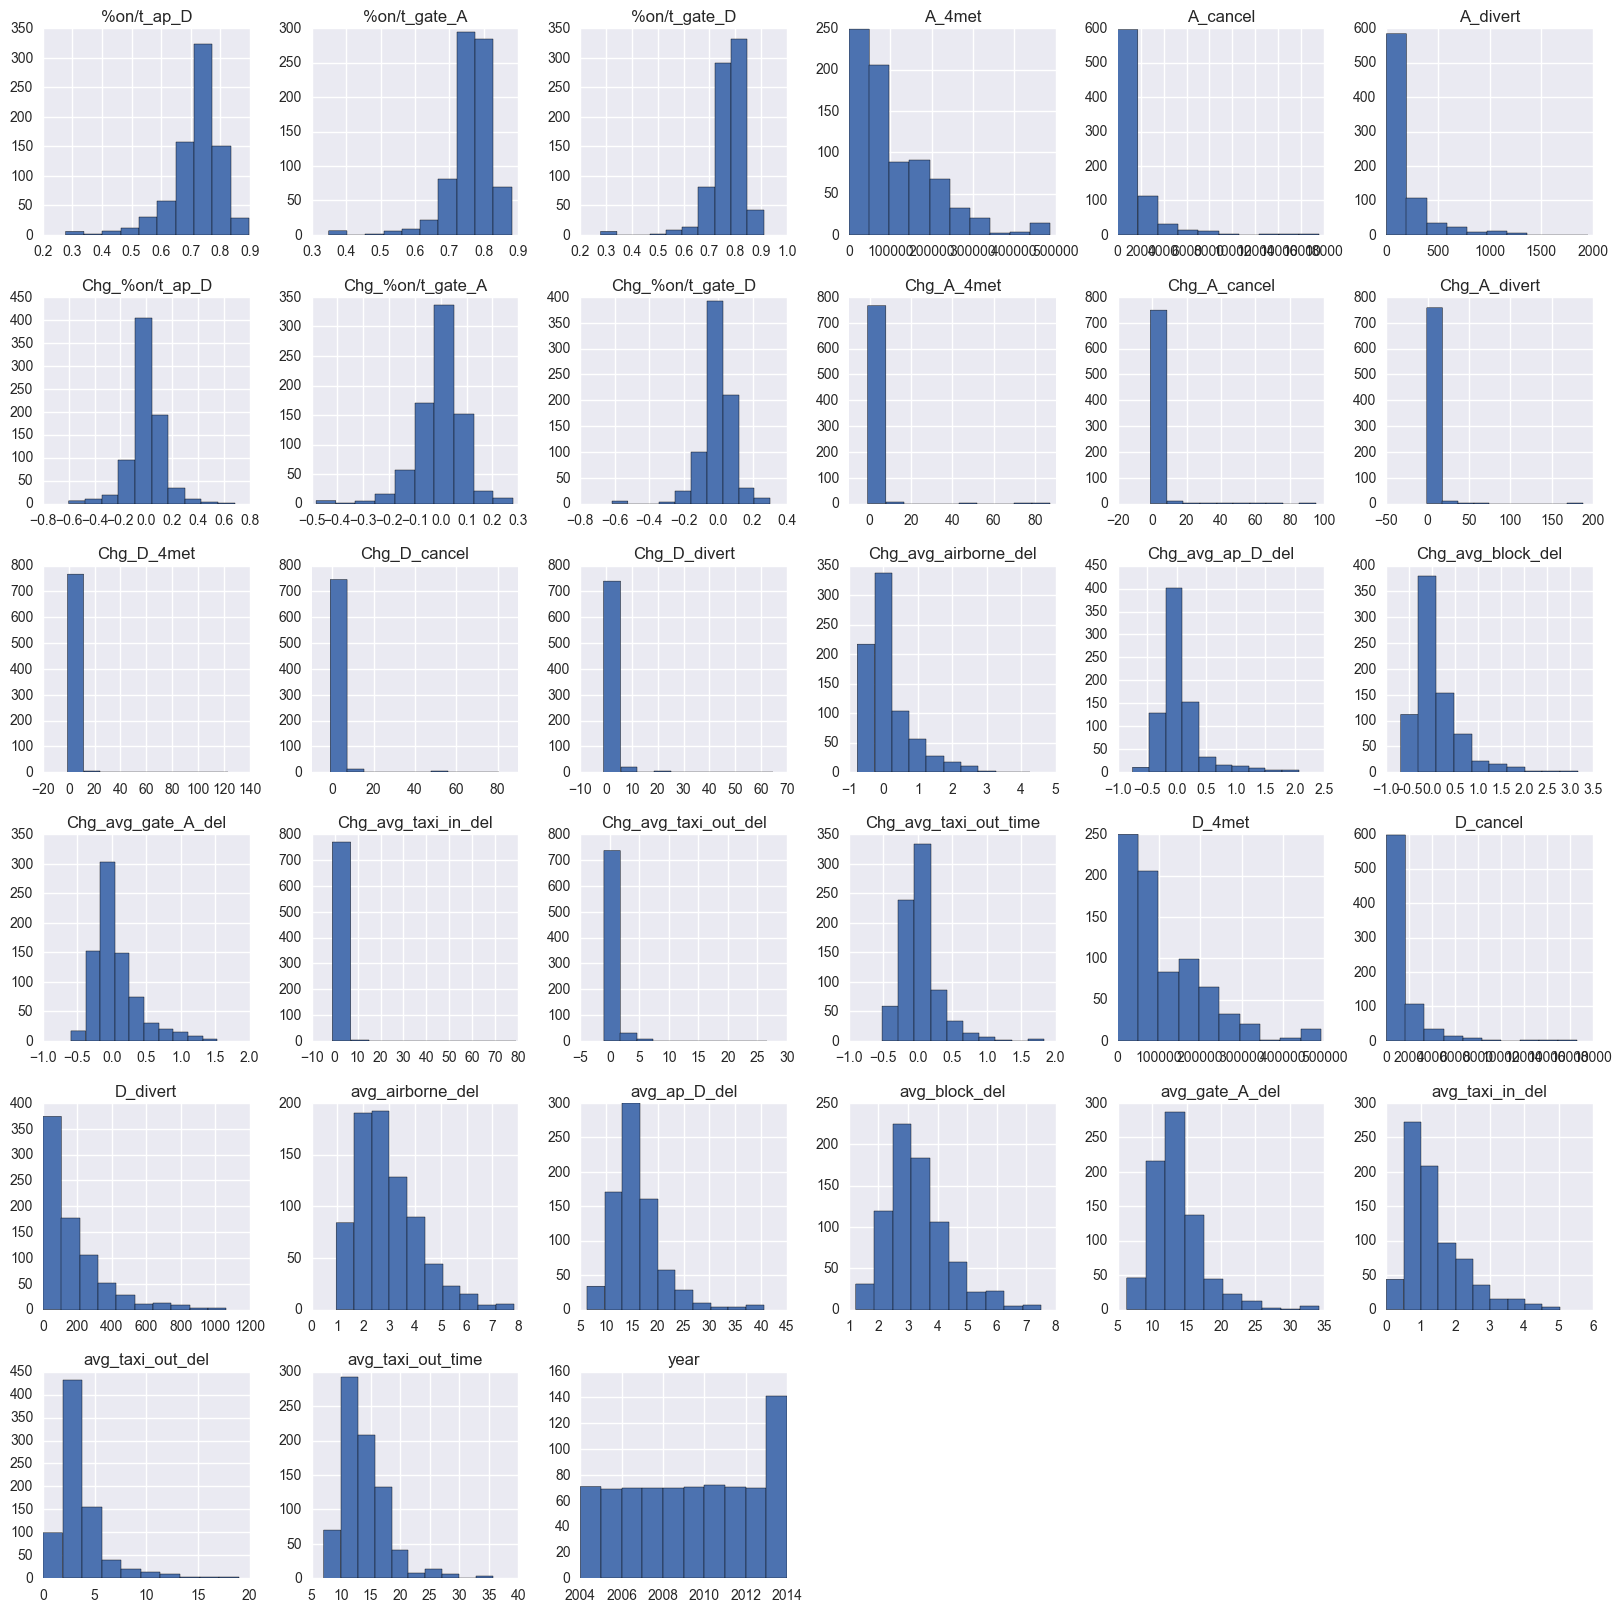

In [54]:

dfn.hist(figsize=(20,20))
# plt.rc({'font.size': 2})

# plt.subplots_adjust(hspace=1)



In [55]:
# xStand = StandardScaler().fit_transform(dfn)

ValueError: could not convert string to float: TUS

In [ ]:
# dfs = pd.DataFrame(xStand)
# dfs.head()

In [ ]:
# dfs.hist(figsize=(10,12))

### Part 4: Define the Data

#### 4.2 Find correlations in the data

In [56]:


df_corr = abs(dfn.corr())
# df_corrdf = pd.DataFrame(df_corr)
# df_corrdf

df_corr = df_corr.applymap(lambda x: x if x >= 0.9 else '')
df_corr

,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
year,1,,,,,,,,,,...,,,,,,,,,,
D_cancel,,1,0.997454,,,,,,,,...,,,,,,,,,,
A_cancel,,0.997454,1,,,,,,,,...,,,,,,,,,,
D_divert,,,,1,,,,,,,...,,,,,,,,,,
A_divert,,,,,1,,,,,,...,,,,,,,,,,
D_4met,,,,,,1,0.999812,,,,...,,,,,,,,,,
A_4met,,,,,,0.999812,1,,,,...,,,,,,,,,,
%on/t_gate_D,,,,,,,,1,,,...,,,,,,,,,,
%on/t_ap_D,,,,,,,,,1,,...,,,,,,,,,,
%on/t_gate_A,,,,,,,,,,1,...,,,,,,,,,,


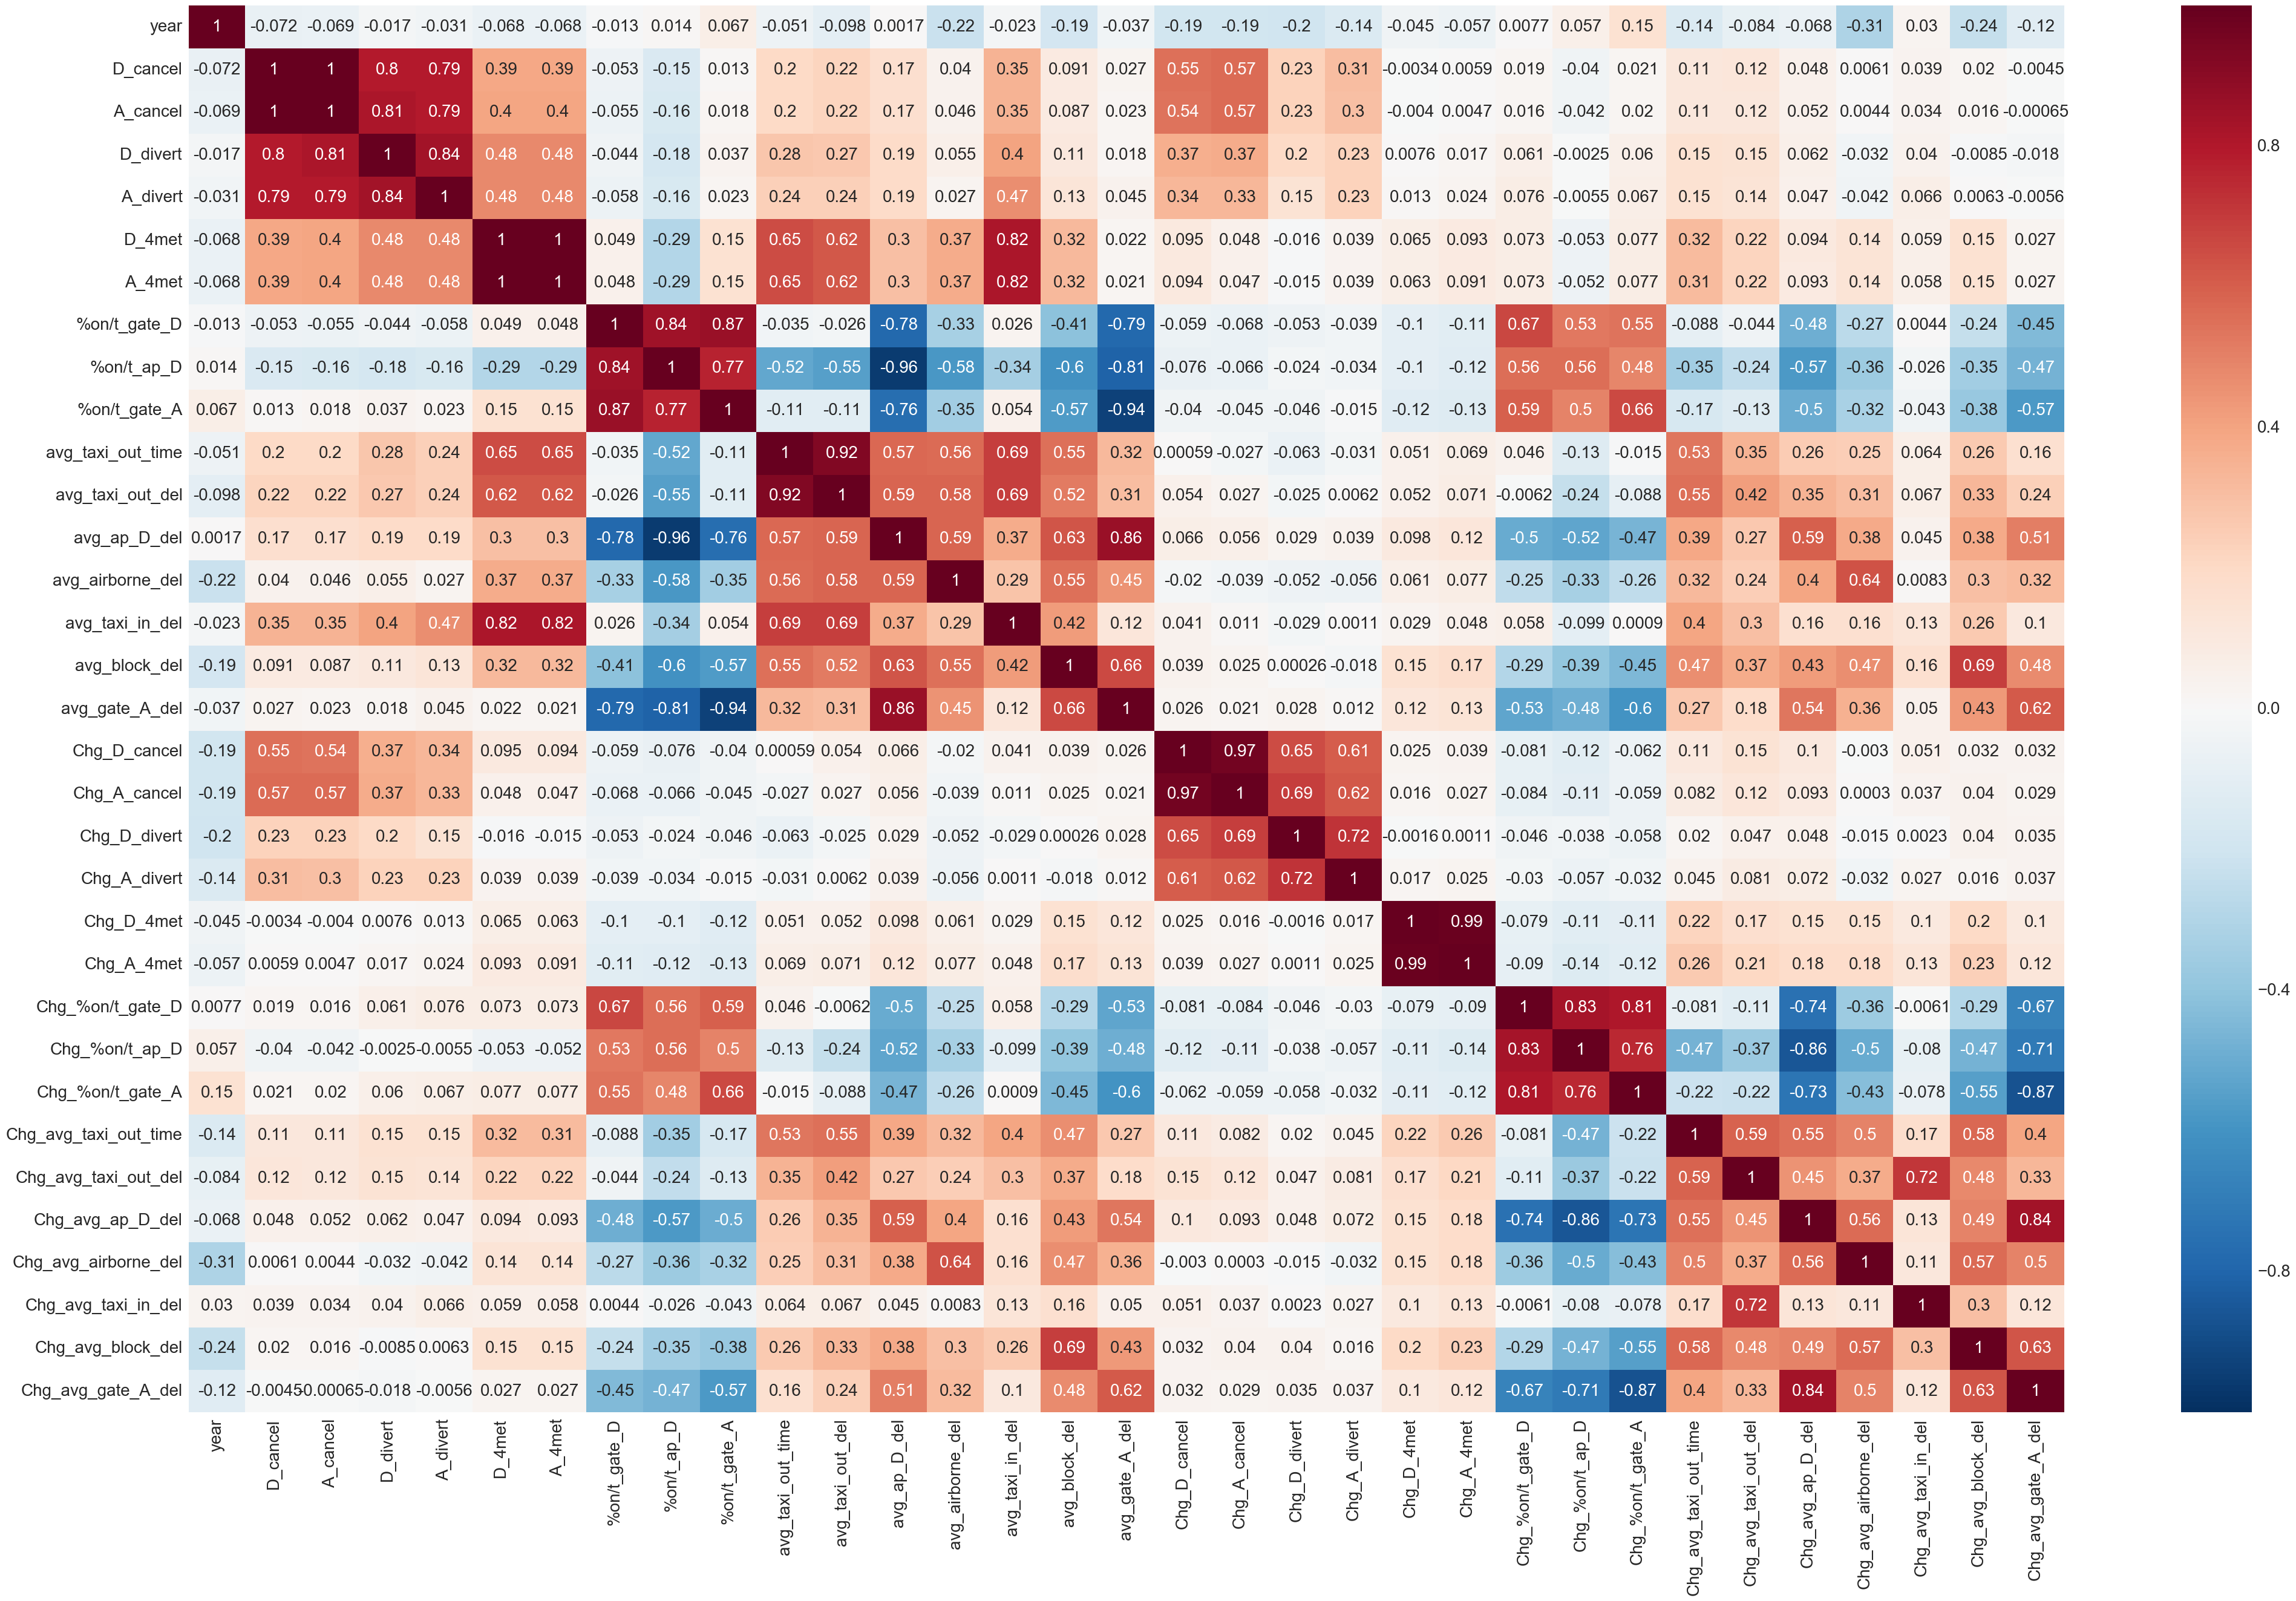

In [61]:

# df_corr = dfn.corr()
dfncr = pd.DataFrame(df_corr)


fig, ax = plt.subplots(figsize=(50,30))   
sns.set(font_scale=2)
ax = sns.heatmap(dfncr, annot=True, annot_kws={"size": 20})


In [63]:
# running again on standardized data and exporting to csv so that I can play with it in Excel
# df_corr14all = df14.corr()
# df_corrdf = pd.DataFrame(df_corr14all)
# df_corrdf
df_corr.to_csv('/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/df_corrdf.csv')

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: to get insight into the amount of colinearity between features  and allow you to decide whether you should eliminate any. 

Checking for pairs with correlations >.95. Will exclude the one of the pair with the greater sum of absolute correlations for all features (the one that has more of its explanatory power already covered by other features). If there is a tie (or close to) I'll favor delays over arrivals.

A - Departure Cancellations and Arrival Cancellations .999 correlated, dropping Arrival Cancellations

B - Deparetures for Metric Computations and Arrivals for Metric Computations .999 correlated, dropping Arrivals

C - Average Airport Departure Delay and Percent on-time airport departures -.96 correlated, dropping Average Airport Departure Delay

D - Average Gate Arrival Delay and Percent on-time gate arrivals -.95 correlated, dropping Percent on-time Gate Arrivals.

_________

Had first done this naive--none of the above exclusions.

After doing this my cumed eigenvalues declined. Testing to see whether I should have done different exclusions if any.

0. Naive
i. ABCD excluded
ii. ABC excluded
iii. ABD excluded
iv. ACD excluded
v. BCD excluded
vi. inverse ABCD (excluded the other partner in the pair)
vii. iABC excluded
viii. iABD excluded
ix. iACD excluded
x. iBCD excluded

Data: Cum PC1 / PC2 / PC3
0.    36 / 66 / 82
i.    37 / 62 / 79
ii.   34 / 64 / 80
iii.  37 / 64 / 80
iv.   40 / 64 / 80
v.    38 / 62 / 80
vi.   37 / 62 / 80
vii.  35 / 64 / 81
viii. 36 / 65 / 81
ix.   41 / 64 / 80
x.    38 / 62 / 81


From this analysis I can see that dropping factors based on correlation is actually harmful and that I had been targeting the wrong member of the correlated pairs.

As a last test I'll look at dropping only one of the inverse members at a time:

dropping iA: 36 / 67 / 81
dropping iB: 35 / 65 / 82
dropping iC: 38 / 64 / 81
dropping iD: 38 / 65 / 81

So it looks like excluding for correlation is the wrong way to go.

In [ ]:
df14.info()

In [36]:
# making new db with only 2012-2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

df1214 = pd.DataFrame(dfn.loc[df['Year'] >= 2012])

df1214.replace([np.inf, -np.inf], np.nan)
df1214.dropna(inplace=True)
df1214.pop('year')
df1214.head()

,ap_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,%on/t_gate_D,%on/t_ap_D,%on/t_gate_A,...,Chg_%on/t_gate_D,Chg_%on/t_ap_D,Chg_%on/t_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
8,ABQ,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,0.8177,...,0.026733,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461
9,ABQ,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,0.7554,...,-0.048501,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498
10,ABQ,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
19,ANC,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,0.8521,...,0.077060,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245
20,ANC,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,0.8631,...,0.057702,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590


In [44]:
dfn2 = pd.DataFrame(df1214)
# dfn2.drop(['D_cancel','D_4met','avg_ap_D_del','Chg_D_cancel', 'Chg_D_4met','Chg_avg_gate_A_del'], axis=1,\
# inplace=True)



dfn2.replace([np.inf, -np.inf], np.nan, inplace=True)
dfn2.dropna(inplace=True)
dfn2.head();
# # dfn2.drop(['average gate arrival delay'], axis=1,\
# # inplace=True)




In [42]:
dfn2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 8 to 803
Data columns (total 33 columns):
ap_name                  213 non-null object
D_cancel                 213 non-null float64
A_cancel                 213 non-null float64
D_divert                 213 non-null float64
A_divert                 213 non-null float64
D_4met                   213 non-null int64
A_4met                   213 non-null int64
%on/t_gate_D             213 non-null float64
%on/t_ap_D               213 non-null float64
%on/t_gate_A             213 non-null float64
avg_taxi_out_time        213 non-null float64
avg_taxi_out_del         213 non-null float64
avg_ap_D_del             213 non-null float64
avg_airborne_del         213 non-null float64
avg_taxi_in_del          213 non-null float64
avg_block_del            213 non-null float64
avg_gate_A_del           213 non-null float64
Chg_D_cancel             213 non-null float64
Chg_A_cancel             213 non-null float64
Chg_D_divert             2

#### 4.5 How can you improve your overall analysis? 

Answer: by dropping those colinear features.

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [64]:
x = dfn.ix[:,1:].values
y = dfn.ix[:,0].values

# x.replace([np.inf, -np.inf], np.nan)
# x.dropna(inplace=True)
# np.set_printoptions(threshold='nan')
# x

In [65]:

bad_indices = np.where(np.isinf(x))

print(bad_indices)

(array([], dtype=int64), array([], dtype=int64))


In [66]:
xStand = StandardScaler().fit_transform(x)
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

In [ ]:
# print(eigenValues)
# print(eigenVectors)

In [67]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0]);

9.61058309167
5.63052775504
3.8539948356
2.513157416
1.83796172772
1.67127550802
1.36057467785
1.14887513812
0.862361109027
0.806040375004
0.567943070064
0.556205259079
0.483568006651
0.303153259922
0.294649929919
0.261960837772
0.231431342652
0.176363807416
0.159514765663
0.148371805046
0.133878469816
0.117542618174
0.0963737878755
0.0674634600366
0.0443444772794
0.0339883914868
0.0263770825981
0.0257467291263
0.00721627307437
0.00620138301778
0.00320645964076
0.0016256186041
0.000157189945847


In [68]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  29.08540103   46.1255906    57.78929344   65.39509536   70.9574898
   76.01542623   80.13305986   83.61000749   86.21985108   88.659246
   90.37806491   92.06136059   93.5248274    94.4422883    95.33401477
   96.12681121   96.82721339   97.36095958   97.84371394   98.29274533
   98.69791419   99.05364434   99.34530929   99.54948023   99.68368405
   99.78654628   99.86637369   99.94429341   99.96613269   99.98490051
   99.99460452   99.99952428  100.        ]


In [1]:
airports_pca2 = PCA(n_components=2)

X2 = airports_pca2.fit_transform(xStand)

# airports_pca2.components_
# components_.X
# plot(X2)

NameError: name 'PCA' is not defined

In [ ]:
PCAdf2 = pd.DataFrame(X2, columns=['PC1','PC2'])
PCAdf2.head()

In [ ]:
j = PCAdf2.PC1
k = PCAdf2.PC2

plt.scatter(j,k)

In [ ]:
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1)
    plt.bar(range(len(cumulvarExpl)), varExpl, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cumulvarExpl)), cumulvarExpl, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
eigen_pairs = [[eigenValues[i], eigenVectors[:,i]] for i in range(len(eigenValues))]
eigen_pairs.sort(reverse=True)

In [ ]:
weight_2d_projection = np.hstack((eigen_pairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigen_pairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection;

In [ ]:
Z2 = x.dot(weight_2d_projection)

In [ ]:
fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=12)
ax.set_ylabel('principal component 2', fontsize=12)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8) 
    
ax.set_title('PC1 vs PC2\n', fontsize=12
            )

plt.show()

In [ ]:
airports_pca3 = PCA(n_components=3)

X3 = airports_pca3.fit_transform(xStand)

In [ ]:
# peida
# pc3 = pca3.fit_transform(df_cluster)

In [ ]:

# peida
print airports_pca3.explained_variance_
print
print airports_pca3.explained_variance_ratio_

airports_pca3.components_

In [ ]:
# peida

pc3df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = pc3df['PC1'] , ys = pc3df['PC2'], zs=pc3df['PC3'], alpha = 0.2, s = 50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [ ]:
PCAdf3 = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
PCAdf3.head()

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [ ]:
db = DBSCAN(eps =1, min_samples=4).fit(xStand)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

In [ ]:
def plot_dbscan(db, X):
    fig = plt.figure(figsize=(5,4))
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
#             Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=3)
        
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)

       
    #plt.gca().set_xlim(-2.5,2.5)
    #plt.gca().set_ylim(-2.5,2.5)
    plt.title('Number of clusters: %d' % n_clusters_);
    
plot_dbscan(db, X3)

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied